In [54]:
import math 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from IPython.display import display
import collections
import json
from copy import deepcopy
from qbstyles import mpl_style

mpl_style(dark=False)

# Supply Chain Environment

In [4]:
class State(object):
    def __init__(self, warehouse_num, T, demand_history, t = 0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    def to_array(self):
        return np.concatenate( 
            ([self.factory_stock], 
             self.warehouse_stock, 
             np.hstack(self.demand_history), 
             [self.t]) )

    def stock_levels(self):
        return np.concatenate( 
            ([self.factory_stock], self.warehouse_stock) )

class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 26               # episode duration
        self.warehouse_num = 3  
        self.d_max = 5            # maximum demand, units
        self.d_var = 2            # maximum random demand variation, units 
    
        self.unit_price = 100     # unit price in dollars
        self.unit_cost = 40       # unit cost in dollars

        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
        self.penalty_unit_cost = self.unit_price
        
        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + 
                        self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(self.warehouse_num, self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
    
        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        total_penalty_cost = - self.penalty_unit_cost * ( np.sum( np.minimum(state.warehouse_stock, 
                                                        np.zeros(self.warehouse_num)) )  +  min(state.factory_stock, 0))
        total_transportation_cost = np.dot(
            self.transporation_costs, action.shippings_to_warehouses)
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # calculating the next state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0]) 
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])    
        next_state.demand_history = list(self.demand_history)

        self.t += 1
        self.demand_history.append(demands)

        return next_state, reward, self.t == self.T - 1

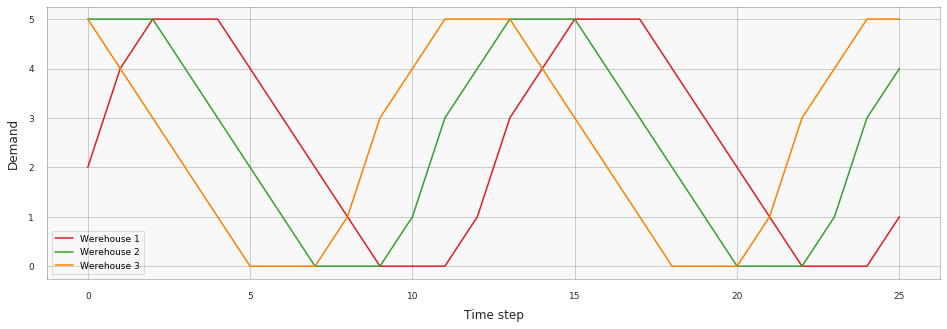

In [6]:
# visualize demand functions for warehouses
env = SupplyChainEnvironment()
demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int)
plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Demand")
plt.plot(range(env.T), demands.T)
plt.legend([f'Werehouse {i+1}' for i in range(env.warehouse_num)])
plt.show()

In [7]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2    
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)
    
    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)
    
    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

# Baseline (s, Q)-Policy

In [8]:
# We use (s, Q)-policy as a baseline 
# The policy is: Order your Economic Order Quantity Q, every time your inventory 
# position drops below s (Reorder Point or Safety Stock).

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]
    
        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock: 
            action.production_level = self.factory_reorder_amount
        else: 
            action.production_level = 0
        return action
    
def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process 
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

# Optimize (s, Q)-policy Parameters with Facebook's Ax

In [10]:
from ax import optimize

def func(p):
    policy = SQPolicy(
        p['factory_s'], 
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },  
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=200,
    )

[INFO 05-08 16:21:51] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 8 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 8 will take longer to generate due to model-fitting.
[INFO 05-08 16:21:51] ax.service.managed_loop: Started full optimization with 200 steps.
[INFO 05-08 16:21:51] ax.service.managed_loop: Running optimization trial 1...
[INFO 05-08 16:21:51] ax.service.managed_loop: Running optimization trial 2...
[INFO 05-08 16:21:51] ax.service.managed_loop: Running optimization trial 3...
[INFO 05-08 16:21:51] ax.service.managed_loop: Running optimization trial 4...
[INFO 05-08 16:21:51] ax.service.managed_loop: Running optimization trial 5...
[INFO 05-08 16:21:51] ax.service.managed_loop: Running optimization trial 6...
[INFO 05-08 16:21:52] ax.service.managed_loop: Running optimization trial 7...
[INFO 05-08 16:21:52] ax.service.managed_loop: Running optimization 

[INFO 05-08 16:24:28] ax.service.managed_loop: Running optimization trial 99...
[INFO 05-08 16:24:29] ax.service.managed_loop: Running optimization trial 100...
[INFO 05-08 16:24:31] ax.service.managed_loop: Running optimization trial 101...
[INFO 05-08 16:24:34] ax.service.managed_loop: Running optimization trial 102...
[INFO 05-08 16:24:36] ax.service.managed_loop: Running optimization trial 103...
[INFO 05-08 16:24:38] ax.service.managed_loop: Running optimization trial 104...
[INFO 05-08 16:24:40] ax.service.managed_loop: Running optimization trial 105...
[INFO 05-08 16:24:42] ax.service.managed_loop: Running optimization trial 106...
[INFO 05-08 16:24:45] ax.service.managed_loop: Running optimization trial 107...
[INFO 05-08 16:24:47] ax.service.managed_loop: Running optimization trial 108...
[INFO 05-08 16:24:49] ax.service.managed_loop: Running optimization trial 109...
[INFO 05-08 16:24:51] ax.service.managed_loop: Running optimization trial 110...
[INFO 05-08 16:24:53] ax.serv

In [11]:
display(best_parameters)
display(best_values)

{'factory_s': 7.706221246017265e-15,
 'factory_Q': 17.267519619379613,
 'w1_s': 8.703364294090969,
 'w1_Q': 5.227963956995396,
 'w2_s': 4.5260950117841645,
 'w2_Q': 7.15715010012239,
 'w3_s': 2.1253201601792537,
 'w3_Q': 11.822781795740813}

({'objective': 5124.341277173098},
 {'objective': {'objective': 126.66466872471908}})

Reward: mean 7273.44, standard deviation 767.5500937398158


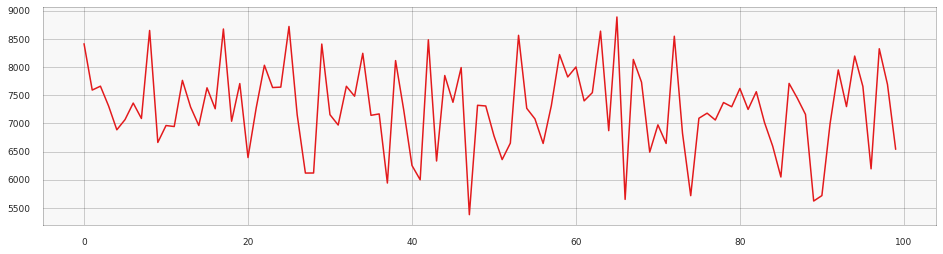

In [12]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

Return is 8658.0


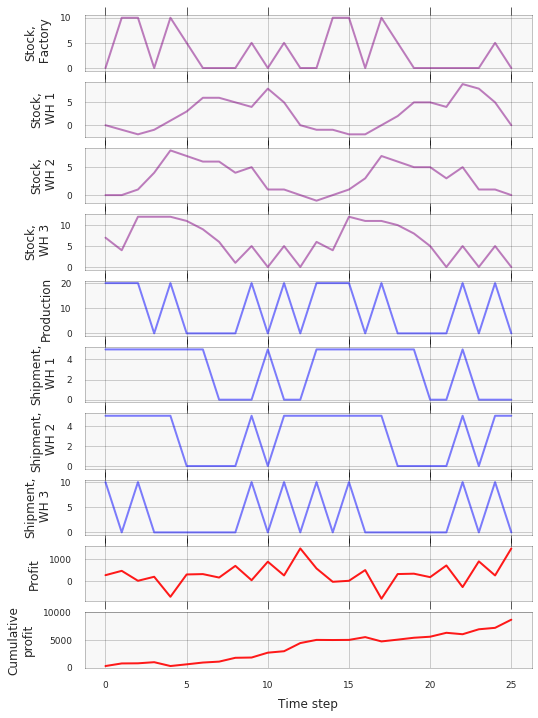

In [13]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

# Optimize (s, Q)-policy with Grid Search

In [14]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

Configuration #0 -- -144093.2
Configuration #100 -- -143381.2
Configuration #200 -- -143381.2
Configuration #300 -- -143381.2
Configuration #400 -- -143381.2
Configuration #500 -- -143381.2
Configuration #600 -- -143381.2
Configuration #700 -- -143381.2
Configuration #800 -- -141062.8
Configuration #900 -- -141062.8
Configuration #1000 -- -141062.8
Configuration #1100 -- -141062.8
Configuration #1200 -- -141062.8
Configuration #1300 -- -141062.8
Configuration #1400 -- -141062.8
Configuration #1500 -- -141062.8
Configuration #1600 -- -141062.8
Configuration #1700 -- -141062.8
Configuration #1800 -- -141062.8
Configuration #1900 -- -141062.8
Configuration #2000 -- -141062.8
Configuration #2100 -- -141062.8
Configuration #2200 -- -3709.1
Configuration #2300 -- -2710.7
Configuration #2400 -- -2710.7
Configuration #2500 -- -2710.7
Configuration #2600 -- -2710.7
Configuration #2700 -- -2710.7
Configuration #2800 -- -2710.7
Configuration #2900 -- -2710.7
Configuration #3000 -- -2710.7
Configu

# Optimize Policy with RLib

In [17]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray import tune
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.rllib import agents
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, 
            shape=(self.supply_chain.warehouse_num + 1,), 
                                dtype=np.int16)
        self.observation_space = Box(-10000, 10000, 
            shape=(len(self.supply_chain.initial_state().to_array()),),
                                     dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}
    
ray.shutdown()
ray.init()

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512] 
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000
    
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    for i in range(10):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

# train_ddpg()

2020-05-08 16:41:12,682	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-08 16:41:12,683	INFO resource_spec.py:216 -- Starting Ray with 4.83 GiB memory available for workers and up to 2.42 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [62]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent(algo='a3c', iters=10, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=SimpleSupplyChain)
    else:
        raise AttributeError('No attribute {}'.format(algo))
    
    results = []
    for n in range(iters):
        result = trainer.train()
        print(pretty_print(result))
        results.append(result)
    
    return trainer, results

In [50]:
config_dict = {'actor_hiddens': [128, 128],
               'critic_hiddens': [128, 128],
               'timesteps_per_iteration': 1000,
               'buffer_size': 10000}

In [65]:
agent, results = train_agent('a3c', 10, config_dict)

2020-05-08 18:07:15,051	WARNING util.py:45 -- Install gputil for GPU system monitoring.


custom_metrics: {}
date: 2020-05-08_18-07-20
done: false
episode_len_mean: 25.0
episode_reward_max: -180958.02846351266
episode_reward_mean: -209342.24221785134
episode_reward_min: -230631.87834471464
episodes_this_iter: 121
episodes_total: 121
experiment_id: c11b62b69fa3495891dc9b0b9298fcca
hostname: ubuntu
info:
  apply_time_ms: 1.166
  dispatch_time_ms: 2.939
  learner:
    cur_lr: 9.999999747378752e-05
    grad_gnorm: 40.00000762939453
    model: {}
    policy_entropy: 81.89337158203125
    policy_loss: -2575276.25
    var_gnorm: 22.945953369140625
    vf_explained_var: 1.0728836059570312e-06
    vf_loss: 5598613504.0
  num_steps_sampled: 3000
  num_steps_trained: 3000
  wait_time_ms: 3.259
iterations_since_restore: 1
node_ip: 192.168.0.11
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_util_percent: 38.5
  ram_util_percent: 43.5625
pid: 14750
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_env_wait_ms: 0.34696027483666153
  mean_

custom_metrics: {}
date: 2020-05-08_18-07-56
done: false
episode_len_mean: 25.0
episode_reward_max: -269896.0
episode_reward_mean: -605304.0054444622
episode_reward_min: -968368.0
episodes_this_iter: 281
episodes_total: 2082
experiment_id: c11b62b69fa3495891dc9b0b9298fcca
hostname: ubuntu
info:
  apply_time_ms: 1.214
  dispatch_time_ms: 3.181
  learner:
    cur_lr: 9.999999747378752e-05
    grad_gnorm: 39.999996185302734
    model: {}
    policy_entropy: 538.2197875976562
    policy_loss: -40310924.0
    var_gnorm: 28.789642333984375
    vf_explained_var: 1.9669532775878906e-06
    vf_loss: 57321910272.0
  num_steps_sampled: 52000
  num_steps_trained: 52000
  wait_time_ms: 3.373
iterations_since_restore: 8
node_ip: 192.168.0.11
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_util_percent: 50.412499999999994
  ram_util_percent: 55.724999999999994
pid: 14750
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_env_wait_ms: 0.3509710658131925

In [66]:
env = agent.env_creator(agent.config)
state = env.reset()

In [69]:
env.action_space.sample()

array([11, 20, 14,  3], dtype=int16)

In [70]:
agent.compute_action(state)

array([20., 20., 20., 20.], dtype=float32)

In [74]:
action = agent.compute_action(state)
state, r, done, _ = env.step(action)
state

array([-40.,  20., -15.,  13.,   0.,   0.,   0.,   5.,   5.,   3.,   5.,
         4.,   2.,   6.,   4.,   2.,   0.])

In [76]:
agent.logdir

'/home/christian/ray_results/A3C_SimpleSupplyChain_2020-05-08_18-07-14vmu3ec04'